In [2]:
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy.polynomial.legendre as lgd
%matplotlib inline
matplotlib.rc('text', usetex=True)
matplotlib.rc('font',size=15)
import sys

def em_line(l_name):
    #Initialize values
    w_out = 0  #The output wavelength
    l_name_out = l_name #The output name.
    #This should probably be done with a dict. But I don't know those yet.
    if l_name == 'LYA': #Lyman-Alpha line. Our favorite.
        w_out = 1215.24
        l_name_out = 'Ly a'
    elif ((l_name == 'OIV')|(l_name == 'SIV')): #Complex is two blended lines.
        w_out = 1399.8
        l_name_out = 'S IV + O IV'
    elif l_name == 'CIV': #Carbon IV. If MgII isn't visible, this is the goto line.
        w_out = 1549.48
        l_name_out = 'C IV'
    elif l_name == 'HEII': #This shows up occassionally I suppose.
        w_out = 1640.4
        l_name_out = 'He II'
    elif l_name == 'CIII': #Shows up more often. Useful for ratio_calc.
        w_out = 1908.734
        l_name_out = 'C III'
    elif l_name == 'CII': #Usually pretty weak.
        w_out = 2326.0
        l_name_out = 'C II'
    elif l_name == 'MGII': #Our most favoritest. Shows up strong at low Z.
        w_out = 2800
        l_name_out = 'Mg II'
    elif l_name == 'LYB': #Occassionally shows up blue of LyA.
        w_out = 1033
        l_name_out = 'Ly b'
    elif l_name == 'OIII': #The red peak of the double horns.
        w_out = 5008
        l_name_out = '[O III]'
    elif l_name == 'HB': #Shows up with OIII. Sometimes a redshift can be found.
        w_out = 4862
        l_name_out = 'H b'
    elif l_name == 'OII': #More for e_calc. Makes it findable for flagging during VI.
        w_out = 3728
        l_name_out = '[O II]'
    elif l_name == 'HG': #H-gamma that can sometimes appear with strength at low z.
        w_out = 4341.68
        l_name_out = 'H g'
    elif l_name == 'HD': #Included for completeness.
        w_out = 4102.89
        l_name_out = 'H d'
    elif l_name == 'HA':
        w_out = 6563
        l_name_out = 'H a'

    return l_name_out,w_out #Send the formatted name and rest wavelength out into the world.

def e_calc(l_name_in,l_z):
    l_in = l_name_in.upper()
    l_n_in, l_r = em_line(l_in)
    l_o = int(float(l_r) * float(l_z + 1))
    if ((l_o < 3600)|(l_o > 9800)):
        l_o = -1
    return l_n_in,l_r,l_o

def p_spec(infile,p_in,m_in,f_in,smoothing_pct=0,ogs=True,err_check=False,sky_check=False,line_labs=False):
    loglam = infile['loglam'] #Extract log values for the x-axis values.
    lam = 10**loglam #Define the x-axis values for the plot.
    flux = infile['flux']

    #Define the axes limits
    x_lower = np.amin(lam)
    x_upper = np.amax(lam)
    vis_range = np.where((lam>=3700)&(lam<=9000))[0]
    y_range = np.amax(flux[vis_range]) - np.amin(flux[vis_range])
    y_pad = float(y_range) / 10
    y_lower = np.amin(flux[vis_range]) - y_pad
    y_upper = np.amax(flux[vis_range]) + y_pad
    y_err = infile['ivar']
    y_sky = infile['sky']
    z_in = 1.533
    em_arr = np.zeros(7,dtype=[('LINE_NAME_IN','U5'),('LINE_NAME_DISP','U11'),('W_REST','f4'),('W_OBS','f4')])
    em_arr['LINE_NAME_IN'][0] = 'lya'
    em_arr['LINE_NAME_IN'][1] = 'siv'
    em_arr['LINE_NAME_IN'][2] = 'civ'
    em_arr['LINE_NAME_IN'][3] = 'ciii'
    em_arr['LINE_NAME_IN'][4] = 'mgii'
    em_arr['LINE_NAME_IN'][5] = 'hb'
    em_arr['LINE_NAME_IN'][6] = 'oiii'
    for i in range(7):
        em_arr['LINE_NAME_DISP'][i],em_arr['W_REST'][i],em_arr['W_OBS'][i] = e_calc(em_arr['LINE_NAME_IN'][i],z_in)
    #print(em_arr)

    if smoothing_pct != 0:
        num_x = len(lam)
        step_smooth = int(num_x / smoothing_pct)
        num_smooth = int(num_x/step_smooth)
        xs_adr = np.arange(0,num_x,num_smooth)
        x_smooth = lam[xs_adr]
        y_smooth = flux[xs_adr]
        y_rolls_mean = np.zeros(len(xs_adr),dtype='f8')
        y_rolls_medn = np.zeros(len(xs_adr),dtype='f8')
        #print(xs_adr)
        for i in range(len(xs_adr)):
            y_flux_temp = flux[xs_adr[i]:xs_adr[i]+9]
            y_rolls_mean[i] = np.mean(y_flux_temp)
            y_rolls_medn[i] = np.median(y_flux_temp)
            
    y_std = np.sqrt(1 / y_err)
    y_flux_err = flux + y_std
    
    
    fig1, ax1 = plt.subplots(nrows=2,ncols=2,sharex='col',sharey='row',figsize=(20,16))
    if err_check == True:
        ax1[0,0].plot(lam,y_err,color='red',linewidth=0.6,label='Flux Error')
    if sky_check == True:
        ax1[0,0].plot(lam,y_sky,color='green',linewidth=0.6,label='Sky Flux')
    ax1[0,0].plot(lam,flux,color='0',linewidth=0.6,label='Original Spectrum')
    if ogs == True:
        ax1[0,1].plot(lam,flux,color='0.75',linewidth=0.6,label='Original Spectrum')
        ax1[1,0].plot(lam,flux,color='0.75',linewidth=0.6,label='Original Spectrum')
        ax1[1,1].plot(lam,flux,color='0.75',linewidth=0.6,label='Original Spectrum')
        #The number is the color of the grey value. 0 is black, 1 is white.
    if smoothing_pct != 0:
        ax1[0,1].plot(x_smooth,y_smooth,color='black',linewidth=0.8,label='Flat Smoothed Spec. ({})'.format(smoothing_pct))
        ax1[1,0].plot(x_smooth,y_rolls_mean,color='blue',linewidth=0.8,label='Mean Smoothed Spec. ({})'.format(smoothing_pct))
        ax1[1,1].plot(x_smooth,y_rolls_medn,color='green',linewidth=0.8,label='Median Smoothed Spec. ({})'.format(smoothing_pct))

    if line_labs == True:    
        for i in range(7):
            if em_arr['W_OBS'][i] != -1.0:
                idx = np.argmin(np.absolute(lam - em_arr['W_OBS'][i]))
                x_line = lam[idx]
                y_line = flux[idx]
                ax1[0,0].annotate(em_arr['LINE_NAME_DISP'][i],xy=(x_line,y_line),xytext=(20,0),textcoords='offset points',
                    bbox=dict(boxstyle='square,pad=0.2', fc='magenta', alpha=0.0),
                    arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=0'))
                ax1[0,1].annotate(em_arr['LINE_NAME_DISP'][i],xy=(x_line,y_line),xytext=(20,0),textcoords='offset points',
                    bbox=dict(boxstyle='square,pad=0.2', fc='magenta', alpha=0.0),
                    arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=0'))
                ax1[1,0].annotate(em_arr['LINE_NAME_DISP'][i],xy=(x_line,y_line),xytext=(20,0),textcoords='offset points',
                    bbox=dict(boxstyle='square,pad=0.2', fc='magenta', alpha=0.0),
                    arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=0'))
                ax1[1,1].annotate(em_arr['LINE_NAME_DISP'][i],xy=(x_line,y_line),xytext=(20,0),textcoords='offset points',
                    bbox=dict(boxstyle='square,pad=0.2', fc='magenta', alpha=0.0),
                    arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=0'))
    #ax1.set_xticks([4000,5000,6000,7000,8000,9000,10000])
    #ax1.set_xticklabels(ax1.get_xticks(),fontsize=15)
    #ax1.set_yticklabels(ax1.get_yticks(),fontsize=15)
    ax1[1,0].set_xlabel(r'Wavelength (\AA)')
    ax1[1,1].set_xlabel(r'Wavelength (\AA)')
    ax1[0,0].set_ylabel(r'$f_{\lambda}$ ($10^{-17}$ ergs s$^{-1}$ cm$^{-2}$\,\AA$^{-1}$)')
    ax1[1,0].set_ylabel(r'$f_{\lambda}$ ($10^{-17}$ ergs s$^{-1}$ cm$^{-2}$\,\AA$^{-1}$)')
    ax1[1,0].set_xlim((x_lower,x_upper))
    ax1[1,1].set_xlim((x_lower,x_upper))
    ax1[0,0].set_ylim((y_lower,y_upper))
    ax1[1,0].set_ylim((y_lower,y_upper))
    ax1[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax1[0,1].xaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax1[1,0].xaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax1[1,1].xaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax1[0,0].yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax1[0,1].yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax1[1,0].yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax1[1,1].yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax1[0,0].tick_params(axis='both',direction='in')
    ax1[1,0].tick_params(axis='both',direction='in')
    ax1[0,1].tick_params(axis='both',direction='in')
    ax1[1,1].tick_params(axis='both',direction='in')
    ax1[0,0].tick_params(axis='both',which='minor',direction='in')
    ax1[0,1].tick_params(axis='both',which='minor',direction='in')
    ax1[1,0].tick_params(axis='both',which='minor',direction='in')
    ax1[1,1].tick_params(axis='both',which='minor',direction='in')
    ax1[0,0].legend(loc='lower left')
    ax1[0,1].legend(loc='lower left')
    ax1[1,0].legend(loc='lower left')
    ax1[1,1].legend(loc='lower left')
    #plt.tight_layout()
    fig1.subplots_adjust(wspace=0,hspace=0)
    #plt.show()
    #plt.savefig('test_fig.png')
    
def file_open(ifile,spct=0,ogspec=True,err=False,sky=False,line_labels=False):
    plate = int(ifile[5:9])
    mjd = int(ifile[10:15])
    fiberid = int(ifile[16:20])
    spec_file = fits.open(ifile)[1].data
    p_spec(spec_file,plate,mjd,fiberid,spct,ogspec,err,sky,line_labels)

#check_smooth = int(sys.argv[1])
#og_check = int(sys.argv[2])
#ptest, mtest, ftest = 7294, 56739, 21
#test_file = '../ica_spec/7294/spec-7294-56739-0021.fits'
#file_open('spec-7294-56739-0021.fits',spct=10,ogspec=True,err=False,sky=False,line_labels=True)


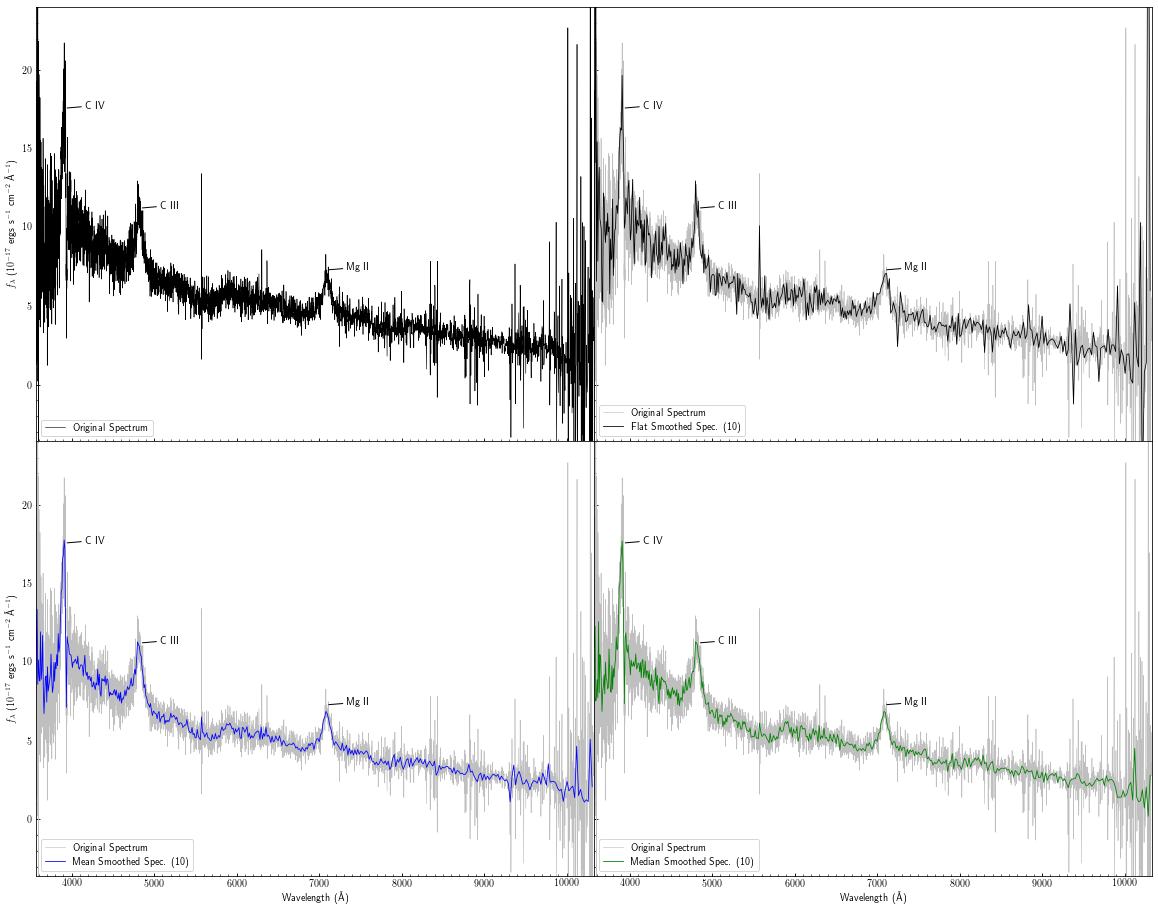

In [4]:
file_open('spec-7294-56739-0021.fits',spct=10,line_labels=True)

In [40]:
def boxcar_smooth(infile,spc):
    spec_file = fits.open(infile)[1].data
    loglam = spec_file['loglam']
    ogflux = spec_file['flux']
    num_flux = len(ogflux)
    ivar = spec_file['ivar']
    lam = 10 ** loglam
    box_flux = np.zeros(num_flux,dtype='f8')
    
    for i in range(num_flux):
        if i < int(spc/2):
            lower = 0
        else:
            lower = -int(spc/2) + i
        if ((int(spc/2) + i) > num_flux):
            upper = num_flux
        else:
            upper = int(spc/2) + i
        noise_temp = np.sqrt(ivar[lower:upper])
        flux_temp = np.average(ogflux[lower:upper],weights=noise_temp)
        box_flux[i] = flux_temp
    pm_lgd = lgd.legfit(lam,box_flux,3)
    y_fit = lgd.legval(lam,pm_lgd)
    
    x_lower = np.amin(lam)
    x_upper = np.amax(lam)
    vis_range = np.where((lam>=3700)&(lam<=9000))[0]
    y_range = np.amax(ogflux[vis_range]) - np.amin(ogflux[vis_range])
    y_pad = float(y_range) / 10
    y_lower = np.amin(ogflux[vis_range]) - y_pad
    y_upper = np.amax(ogflux[vis_range]) + y_pad
    
    y_shrinks = ogflux - y_fit
    y_shrinkd = ogflux / y_fit
    
    fig2,ax2 = plt.subplots(nrows=3,ncols=1,figsize=(20,16),sharex='col')
    ax2[0].plot(lam,ogflux,color='0.75')
    ax2[0].plot(lam,box_flux,color='blue')
    ax2[0].plot(lam,y_fit,color='green')
    ax2[1].plot(lam,y_shrinks)
    ax2[2].plot(lam,y_shrinkd)
    ax2[0].set_xlim((x_lower,x_upper))
    ax2[2].set_xlabel(r'Wavelength (\AA)')
    for i in range(3):
        if i < 2:
            ax2[i].set_ylim((y_lower,y_upper))
            ax2[i].set_ylabel(r'$f_{\lambda}$ ($10^{-17}$ ergs s$^{-1}$ cm$^{-2}$\,\AA$^{-1}$)')
        else:
            ax2[i].set_ylim((0,5))
            ax2[i].set_ylabel(r'Rel. Flux')
        ax2[i].tick_params(axis='both',direction='in')
        ax2[i].tick_params(axis='both',which='minor',direction='in')
        ax2[i].xaxis.set_minor_locator(ticker.MultipleLocator(100))
        ax2[i].yaxis.set_minor_locator(ticker.MultipleLocator(1))
        
    fig2.subplots_adjust(wspace=0,hspace=0)

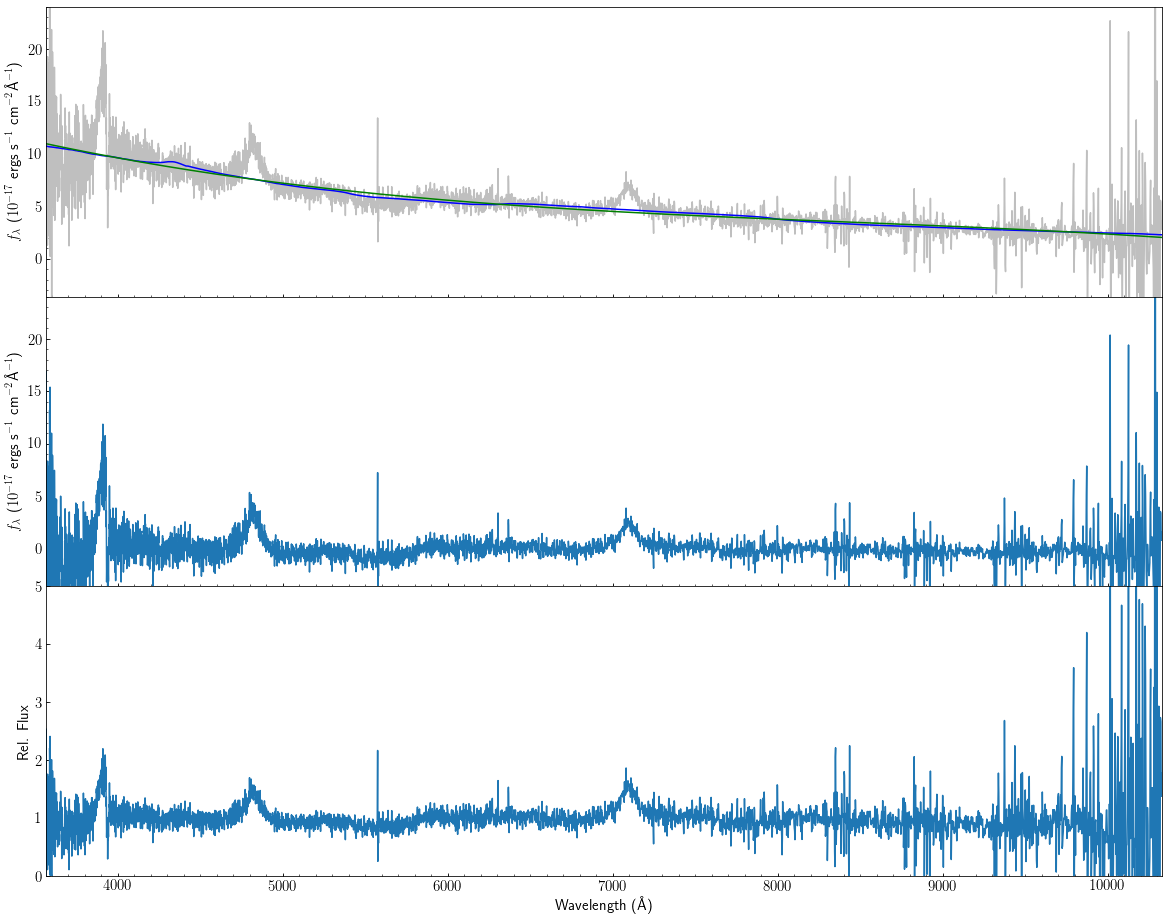

In [42]:
boxcar_smooth('spec-7294-56739-0021.fits',1000)